In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
import sys
import os
import logging
import warnings
from darts.models import (
    RNNModel,
    TCNModel,
    TransformerModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
    Prophet,
)
from darts.metrics import mape, smape, mae, mse, mase
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline

C:\Users\saoedoss\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
logging.disable(logging.CRITICAL)
warnings.filterwarnings("ignore")

In [3]:
torch.cuda.is_available()

True

In [4]:
def generate_torch_kwargs():
    # run torch models on device, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "gpu",
            "devices": [0],
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }

In [5]:
# Adicionar a pasta 'src' ao caminho do sistema
sys.path.append(os.path.abspath(os.path.join("..", "src")))

# Agora você pode importar o módulo utils Ou importar funções específicas do módulo
from metrics import LogTime, eval_model
from ts_plots import plot_forecast

## 1. Read Data

In [6]:
CHECKPOINTS_PATH = os.path.join(os.pardir, "checkpoints")
df_static = pd.read_parquet(os.path.join(CHECKPOINTS_PATH, "5G_df_static.parquet.gzip"))

In [7]:
target_columns = ["RSRP", "RSRQ", "SNR", "CQI", "RSSI"]
static_uids = sorted(df_static.Uid.unique().tolist())
len(static_uids)

23

## 2. Preprocessing

In [8]:
# test_df = (
#     df_static[df_static.Uid == static_uids[12]][target_columns].asfreq(freq="S").bfill()
# )
test_df = df_static[df_static.Uid == static_uids[10]][target_columns].asfreq(freq="S")
ts_static = TimeSeries.from_dataframe(test_df, value_cols=target_columns)

In [9]:
filler = MissingValuesFiller()
scaler = Scaler()
pipe = Pipeline([filler, scaler])
transformed = pipe.fit_transform(ts_static)

<Axes: xlabel='Timestamp'>

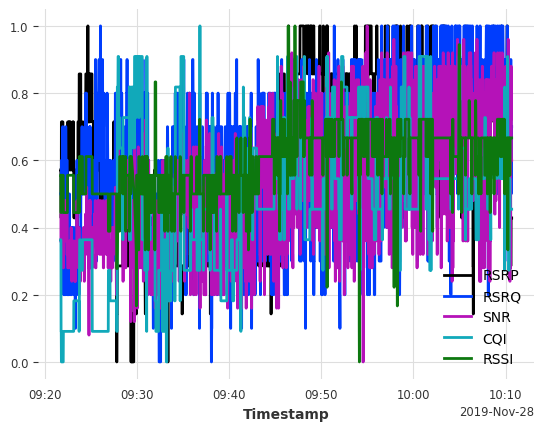

In [10]:
transformed.plot()

<Axes: xlabel='Timestamp'>

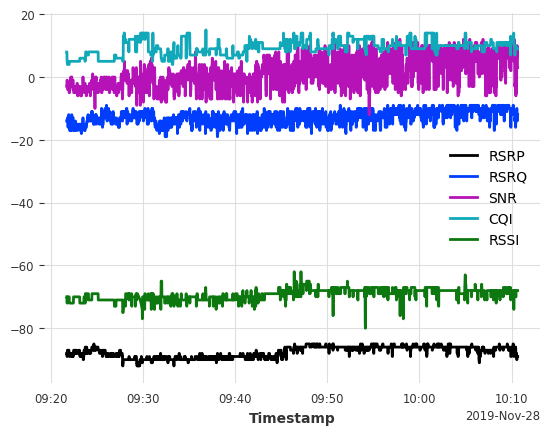

In [11]:
back = pipe.inverse_transform(transformed, partial=True)
back.plot()

## 3. Train/Test Split

Vamos manter _ últimos segundos para validação.

In [12]:
# Separar os timeseries
ts_train, ts_actual = transformed.split_after(0.8)
len(ts_actual)

587

> Corrigir funções de eval para levar em conta o horizonte $H$ desejado de previsão.

In [13]:
H = 60

In [14]:
ts_train, ts_actual = transformed[:-H], transformed[-H:]
len(ts_actual)

60

### Global Forecasting Models
---
Darts contém muitos modelos de previsão, mas nem todos podem ser treinados em várias séries temporais. Os modelos que suportam treinamento em múltiplas séries são chamados de modelos globais. Uma lista exaustiva dos modelos globais pode ser encontrada nessa [tabela](https://unit8co.github.io/darts/README.html#forecasting-models) com, por exemplo:

- LinearRegressionModel
- BlockRNNModel
- Redes Neurais Convolucionais Temporais (TCNModel)
- N-Beats (NBEATSModel)
- TiDEModel

A seguir, distinguiremos dois tipos de séries temporais:

- A **série temporal alvo** é a série temporal que estamos interessados em prever (dada sua história).
    
- Uma **série temporal covariável** é uma série temporal que pode ajudar na previsão da série alvo, mas que não estamos interessados em prever. Às vezes, também é chamada de dados externos.

> Nota: Covariáveis estáticas são invariantes no tempo e correspondem a informações adicionais associadas aos componentes da **série temporal alvo**. Informações detalhadas sobre esse tipo de covariável podem ser encontradas no [notebook](https://unit8co.github.io/darts/examples/15-static-covariates.html) de covariáveis estáticas.

Diferenciamos ainda as séries de covariáveis, dependendo se elas podem ser conhecidas com antecedência ou não:

- **Covariáveis passadas**: denotam séries temporais cujos valores passados são conhecidos no momento da previsão. Geralmente, são coisas que precisam ser medidas ou observadas.
    
- **Covariáveis futuras**: denotam séries temporais cujos valores futuros já são conhecidos no momento da previsão para o período do horizonte de previsão. Podem, por exemplo, representar feriados futuros conhecidos ou previsões meteorológicas.

Alguns modelos usam apenas covariáveis passadas, outros usam apenas covariáveis futuras, e alguns modelos podem usar ambos.

Todos os modelos globais listados acima suportam treinamento em múltiplas séries. Além disso, todos eles suportam séries multivariadas. Isso significa que podem ser usados sem problemas com séries temporais de mais de uma dimensão; a série alvo pode conter uma (como é frequentemente o caso) ou várias dimensões. Uma série temporal com várias dimensões é, na verdade, apenas uma série temporal regular onde os valores em cada marca temporal são vetores em vez de escalares.

---


### Exemplo
---
Os modelos BlockRNNModel, N-Beats, TCN e Transformer seguem uma arquitetura "block". Eles contêm uma rede neural que recebe blocos de séries temporais como entrada e gera blocos de valores futuros (previstos) da série temporal como saída. A dimensionalidade da entrada é o número de dimensões (componentes) da série alvo, mais o número de componentes de todas as covariáveis - empilhados juntos. A dimensionalidade da saída é simplesmente o número de dimensões da série alvo.

![](https://raw.githubusercontent.com/unit8co/darts/a646adf10fa73d8facb16a611f8a3682dc8a1191/examples/static/images/global_io_covs.png)

O `RNNModel` funciona de maneira diferente, de forma recorrente (o que também explica por que eles suportam covariáveis futuras). A boa notícia é que, como usuários, não precisamos nos preocupar muito com os diferentes tipos de modelos e dimensionalidades de entrada/saída. As dimensionalidades são automaticamente inferidas pelo modelo com base nos dados de treinamento, e o suporte para covariáveis passadas ou futuras é simplesmente tratado pelos argumentos `past_covariates` ou `future_covariates`.

Ainda assim, teremos que especificar dois parâmetros importantes ao construir nossos modelos:

- `input_chunk_length`: este é o comprimento da janela de retrospectiva do modelo; portanto, cada saída será calculada pelo modelo lendo os pontos dos ``input_chunk_length`` anteriores.
- `output_chunk_length`: este é o comprimento das saídas (previsões) produzidas pelo modelo interno. No entanto, o método `predict()` do modelo Darts "externo" (por exemplo, o do `NBEATSModel`, `TCNModel`, etc.) pode ser chamado para um horizonte de tempo mais longo. Nesses casos, se o `predict()` for chamado para um horizonte mais longo do que o `output_chunk_length`, o modelo interno será simplesmente chamado repetidamente, alimentando-se de suas próprias saídas anteriores de forma autorregressiva. Se `past_covariates` forem usadas, isso requer que essas covariáveis sejam conhecidas com antecedência suficiente.

---

### Exemplo com uma série de teste:
> Working progress. Notebook para referencia: https://github.com/unit8co/darts/blob/master/examples/01-multi-time-series-and-covariates.ipynb

In [15]:
def fit_and_pred(model, training, validation):
    model.fit(training)
    forecast = model.predict(len(validation))
    return forecast

N-BEATS

In [16]:
model_NBEATS = NBEATSModel(
    input_chunk_length=2 * H,
    output_chunk_length=H,
    n_epochs=100,
    random_state=None,
    **generate_torch_kwargs()
)

In [17]:
model_NBEATS.fit(ts_train)

Epoch 99: 100%|██████████| 85/85 [00:09<00:00,  8.66it/s, train_loss=0.00375]


NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=30, num_blocks=1, num_layers=4, layer_widths=256, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=120, output_chunk_length=60, n_epochs=100, random_state=None, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0], 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x0000021513F6B100>]})

In [18]:
forecast = model_NBEATS.predict(len(ts_actual))

<Axes: xlabel='Timestamp'>

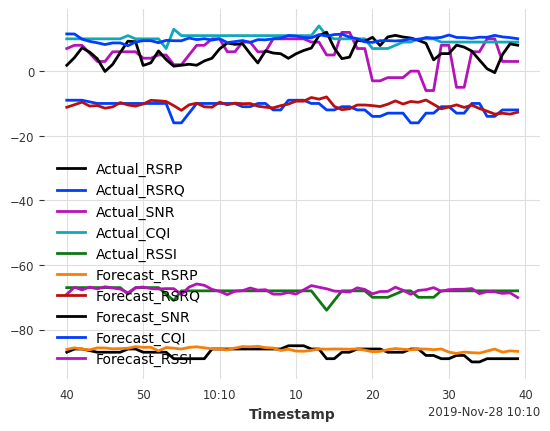

In [19]:
pipe.inverse_transform(ts_actual, partial=True).plot(label="Actual")
pipe.inverse_transform(forecast, partial=True).plot(label="Forecast")

In [23]:
{
    "MAE": mae(actual_series=ts_actual, pred_series=forecast),
    "MSE": mse(actual_series=ts_actual, pred_series=forecast),
    "MASE": mase(actual_series=ts_actual, pred_series=forecast, insample=ts_train),
}

{'MAE': 0.14441620244782,
 'MSE': 0.03930378841633079,
 'MASE': 4.173965445279341}

VARIMA

In [24]:
model_VARIMA = VARIMA(p=16, d=1, q=0, trend="n")

In [25]:
forecast_VARIMA = fit_and_pred(model_VARIMA, ts_train, ts_actual)

In [26]:
{
    "MAE": mae(actual_series=ts_actual, pred_series=forecast_VARIMA),
    "MSE": mse(actual_series=ts_actual, pred_series=forecast_VARIMA),
    "MASE": mase(
        actual_series=ts_actual, pred_series=forecast_VARIMA, insample=ts_train
    ),
}

{'MAE': 0.12999678718622656,
 'MSE': 0.03808513427618988,
 'MASE': 3.534372088928977}

<Axes: xlabel='Timestamp'>

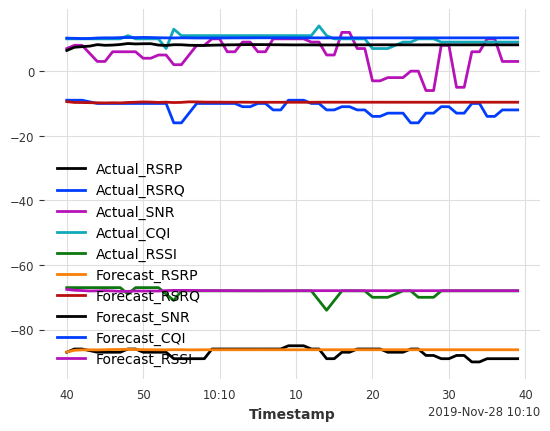

In [27]:
pipe.inverse_transform(ts_actual, partial=True).plot(label="Actual")
pipe.inverse_transform(forecast_VARIMA, partial=True).plot(label="Forecast")

Prophet

In [28]:
seasonal_periods = [16, 12, 15, 48, 13]

In [29]:
def fit_prophet_to_series_with_seasonality(
    training: TimeSeries, validation: TimeSeries, seasonal_period: int
) -> TimeSeries:
    model = Prophet(
        add_seasonalities=[
            {
                "name": "custom_seasonality",
                "seasonal_periods": seasonal_period,
                "fourier_order": 5,
            }
        ]
    )
    model.fit(training)
    prediction = model.predict(len(validation))
    return prediction

In [30]:
forecast_Prophet_RSRP = fit_prophet_to_series_with_seasonality(
    ts_train["RSRP"], ts_actual["RSRP"], seasonal_periods[0]
)
forecast_Prophet_RSRQ = fit_prophet_to_series_with_seasonality(
    ts_train["RSRQ"], ts_actual["RSRQ"], seasonal_periods[1]
)
forecast_Prophet_SNR = fit_prophet_to_series_with_seasonality(
    ts_train["SNR"], ts_actual["SNR"], seasonal_periods[2]
)
forecast_Prophet_CQI = fit_prophet_to_series_with_seasonality(
    ts_train["CQI"], ts_actual["CQI"], seasonal_periods[3]
)
forecast_Prophet_RSSI = fit_prophet_to_series_with_seasonality(
    ts_train["RSSI"], ts_actual["RSSI"], seasonal_periods[4]
)

In [31]:
{
    "MAE": mae(actual_series=ts_actual["RSRP"], pred_series=forecast_Prophet_RSRP),
    "MSE": mse(actual_series=ts_actual["RSRP"], pred_series=forecast_Prophet_RSRP),
    "MASE": mase(
        actual_series=ts_actual["RSRP"],
        pred_series=forecast_Prophet_RSRP,
        insample=ts_train["RSRP"],
    ),
}

{'MAE': 0.16432126275485398,
 'MSE': 0.04290494598789336,
 'MASE': 5.410499450249025}

In [32]:
{
    "MAE": mae(actual_series=ts_actual["RSRQ"], pred_series=forecast_Prophet_RSRQ),
    "MSE": mse(actual_series=ts_actual["RSRQ"], pred_series=forecast_Prophet_RSRQ),
    "MASE": mase(
        actual_series=ts_actual["RSRQ"],
        pred_series=forecast_Prophet_RSRQ,
        insample=ts_train["RSRQ"],
    ),
}

{'MAE': 0.15854151592215776,
 'MSE': 0.045132764650196826,
 'MASE': 2.2065293789844134}

In [33]:
{
    "MAE": mae(actual_series=ts_actual["SNR"], pred_series=forecast_Prophet_SNR),
    "MSE": mse(actual_series=ts_actual["SNR"], pred_series=forecast_Prophet_SNR),
    "MASE": mase(
        actual_series=ts_actual["SNR"],
        pred_series=forecast_Prophet_SNR,
        insample=ts_train["SNR"],
    ),
}

{'MAE': 0.13977194009831215,
 'MSE': 0.03593899100563551,
 'MASE': 1.9745603413416688}

In [34]:
{
    "MAE": mae(actual_series=ts_actual["CQI"], pred_series=forecast_Prophet_CQI),
    "MSE": mse(actual_series=ts_actual["CQI"], pred_series=forecast_Prophet_CQI),
    "MASE": mase(
        actual_series=ts_actual["CQI"],
        pred_series=forecast_Prophet_CQI,
        insample=ts_train["CQI"],
    ),
}

{'MAE': 0.08846013518133354,
 'MSE': 0.014567010078254648,
 'MASE': 4.676553032813844}

In [35]:
{
    "MAE": mae(actual_series=ts_actual["RSSI"], pred_series=forecast_Prophet_RSSI),
    "MSE": mse(actual_series=ts_actual["RSSI"], pred_series=forecast_Prophet_RSSI),
    "MASE": mase(
        actual_series=ts_actual["RSSI"],
        pred_series=forecast_Prophet_RSSI,
        insample=ts_train["RSSI"],
    ),
}

{'MAE': 0.043232966985128955,
 'MSE': 0.0051057462851204025,
 'MASE': 2.5560318263710755}

<Axes: xlabel='Timestamp'>

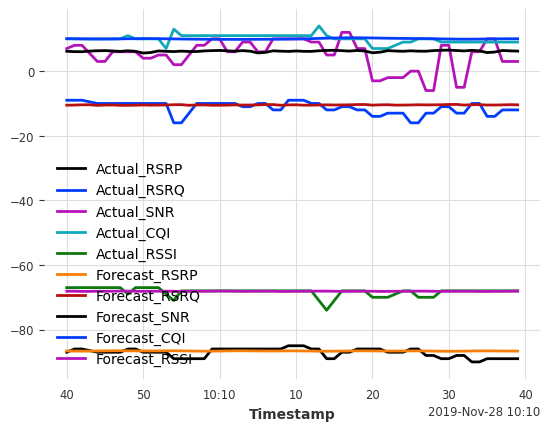

In [36]:
forecast_combined = concatenate(
    [
        forecast_Prophet_RSRP,
        forecast_Prophet_RSRQ,
        forecast_Prophet_SNR,
        forecast_Prophet_CQI,
        forecast_Prophet_RSSI,
    ],
    axis=1,
)

pipe.inverse_transform(ts_actual, partial=True).plot(label="Actual")
pipe.inverse_transform(
    forecast_combined,
    partial=True,
).plot(label="Forecast")

### Pipeline para multiplas séries

> Working progress. Notebook para referencia: https://github.com/unit8co/darts/blob/master/examples/14-transfer-learning.ipynb

In [37]:
multiple_df = df_static[target_columns].asfreq(freq="S")
multiple_ts = TimeSeries.from_dataframe(multiple_df, value_cols=target_columns)

In [38]:
filler = MissingValuesFiller()
scaler = Scaler()
pipe = Pipeline([filler, scaler])
transformed = pipe.fit_transform(ts_static)